In [1]:
import os
import librosa.display
import numpy as np
from data_preprocess import extract_features, extract_stft_features
import matplotlib.pyplot as plt

In [2]:
def load_test_files(directory, desired_time=2.0, n_mels=128, n_fft=2048, hop_length=512):
    """
    載入測試資料，包括正常和異常資料。
    """
    test_files = []
    y_test = []
    for dir in os.listdir(directory):
        if 'no-leak' in dir:
            label = 0
        else:
            label = 1
        y_test.append(label)
        dir_path = os.path.join(directory, dir)
        if not os.path.isdir(dir_path):
            continue
        for file in os.listdir(dir_path):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(dir_path, file)
            y, sr = librosa.load(file_path, sr=None)
            # print(f"載入 {file_path}，取樣率: {sr}")
            
            test_files.append(y)
    
    X_test = np.array(test_files)
    print(f"測試資料形狀: {X_test.shape}")
    y_test = np.array(y_test)
    return X_test, y_test

def random_load_files( directory: str, n_files = 0,):
    """
    隨機選取 n_files 個檔案。
    """
    X_test, y_test = load_test_files(directory=directory)
    indices = np.random.choice(len(X_test), n_files if n_files > 0 else len(X_test), replace=False)
    return X_test[indices], y_test[indices]

In [3]:
def plot_mel_spectrogram(mel_spectrogram, sr, hop_length):
    """
    繪製 Mel 頻譜圖。

    Args:
        mel_spectrogram (np.ndarray): Mel 頻譜圖，形狀為 (時間, n_mels)。
        sr (int): 取樣率。
        hop_length (int): hop length。
    """
    plt.figure(figsize=(10, 4))
    # 繪製 Mel 頻譜圖
    librosa.display.specshow(mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()
    
    
def plot_stft(S_db, sr, hop_length=512):
    """
    繪製音訊的短時傅立葉變換（STFT）。

    Args:
        audio (np.ndarray): 音訊資料。
        sr (int): 取樣率。
        hop_length (int): hop length。
    """


    # 繪製 STFT 頻譜圖
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title('STFT Magnitude')
    plt.tight_layout()
    plt.show()

In [4]:
# 載入測試資料
X_test, y_test = random_load_files(n_files=25, directory='training_data')

載入 training_data\leak\102.wav，取樣率: 48000
載入 training_data\leak\103.wav，取樣率: 48000
載入 training_data\leak\107.wav，取樣率: 48000
載入 training_data\leak\108.wav，取樣率: 48000
載入 training_data\leak\109.wav，取樣率: 48000
載入 training_data\leak\163.wav，取樣率: 48000
載入 training_data\leak\164.wav，取樣率: 48000
載入 training_data\leak\165.wav，取樣率: 48000
載入 training_data\leak\166.wav，取樣率: 48000
載入 training_data\leak\167.wav，取樣率: 48000
載入 training_data\leak\18p113321.wav，取樣率: 48000
載入 training_data\leak\2020-05-14T141740.wav，取樣率: 48000
載入 training_data\leak\2020-05-14T141842.wav，取樣率: 48000
載入 training_data\leak\2020-05-14T141859.wav，取樣率: 48000
載入 training_data\leak\2020-05-14T151140.wav，取樣率: 48000
載入 training_data\leak\2020-05-14T151146.wav，取樣率: 48000
載入 training_data\leak\2020-06-12T112009.wav，取樣率: 48000
載入 training_data\leak\2020-06-12T112014.wav，取樣率: 48000
載入 training_data\leak\2020-06-12T112020.wav，取樣率: 48000
載入 training_data\leak\2020-06-12T112047.wav，取樣率: 48000
載入 training_data\leak\2020-06-12T112052.wav，取樣率:

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (13222,) + inhomogeneous part.

(192, 188)


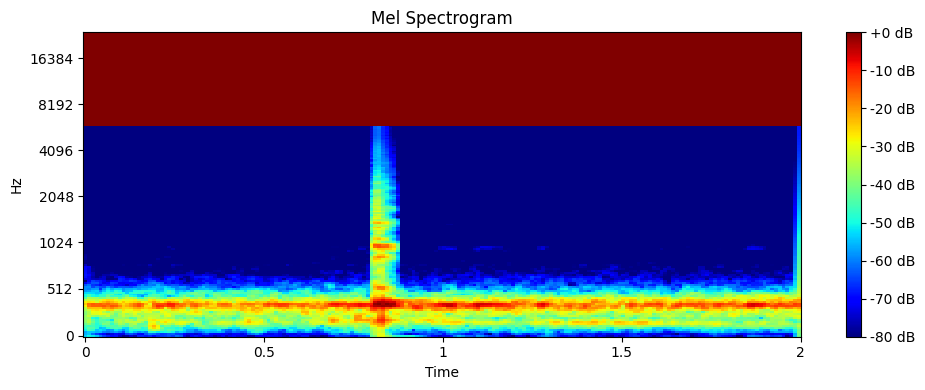

(192, 188)


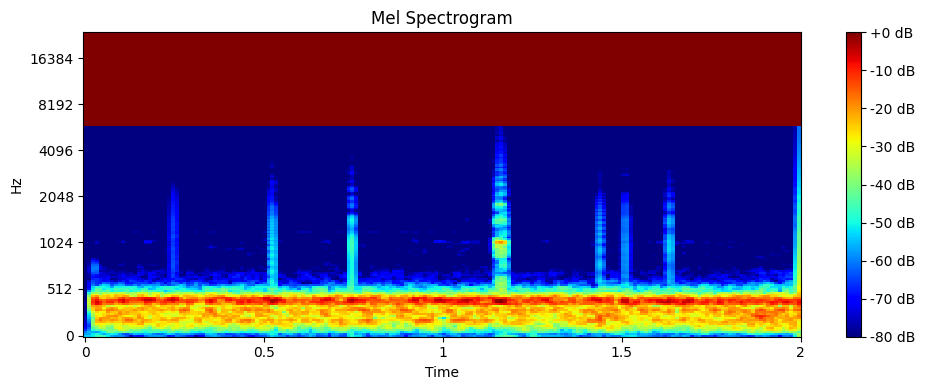

(192, 188)


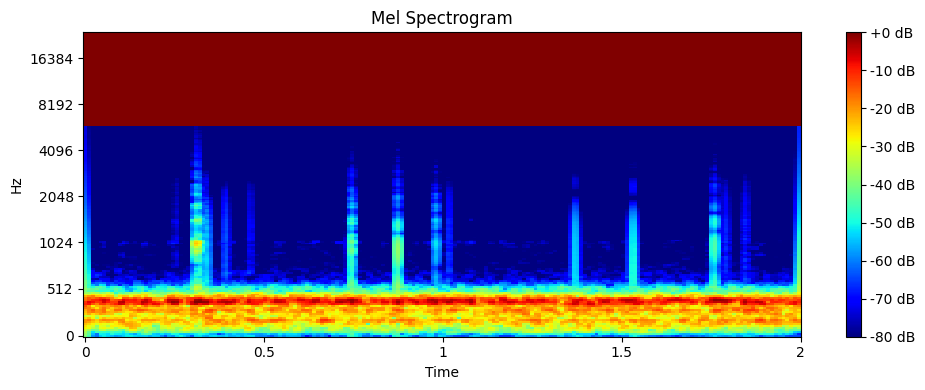

(192, 188)


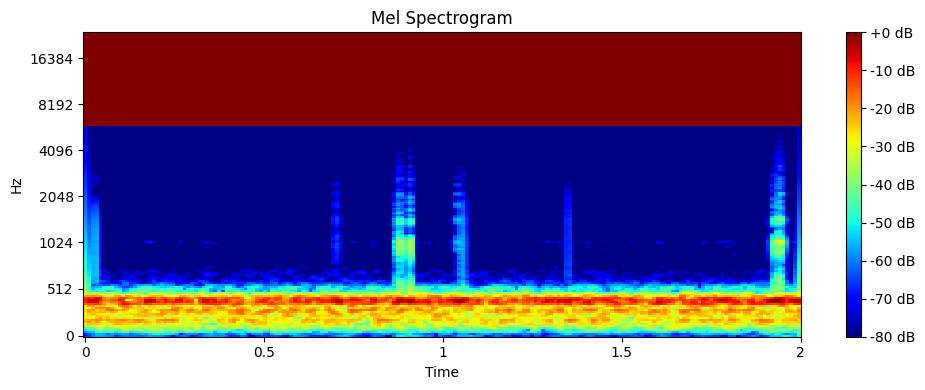

(192, 188)


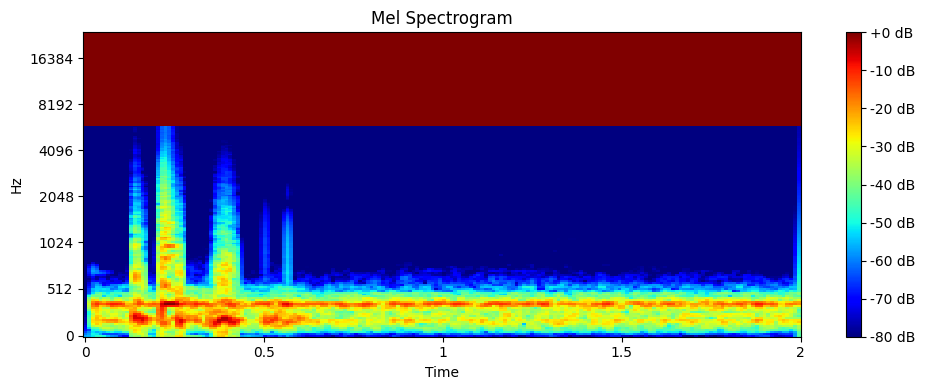

(192, 188)


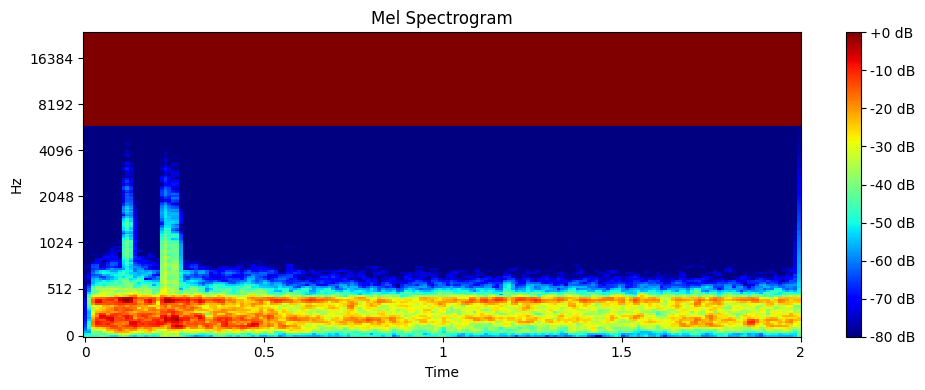

(192, 188)


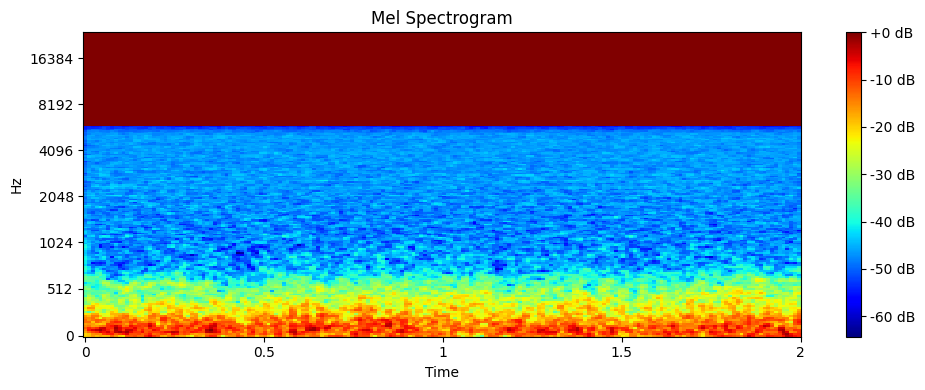

In [24]:
# 繪製 Mel 頻譜圖
for i in X_test:
    mel_spectrogram = extract_features(i, sr=48000, n_mels=128, n_fft=2048, hop_length=512)
    print(mel_spectrogram.shape)
    plot_mel_spectrogram(mel_spectrogram, sr=48000, hop_length=512)

(192, 188)


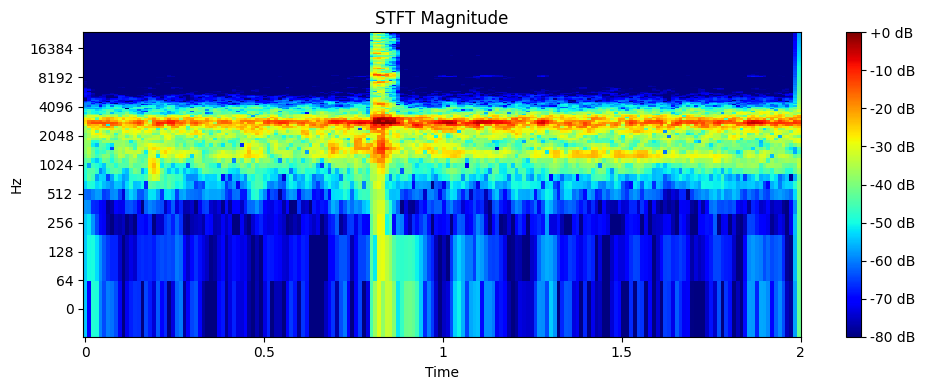

(192, 188)


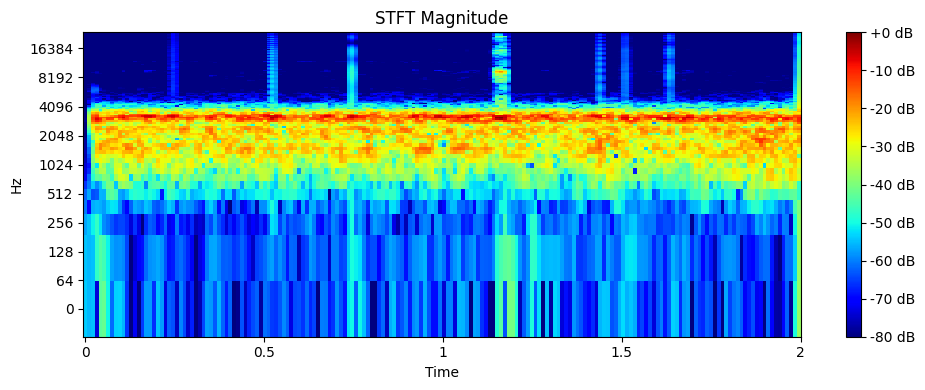

(192, 188)


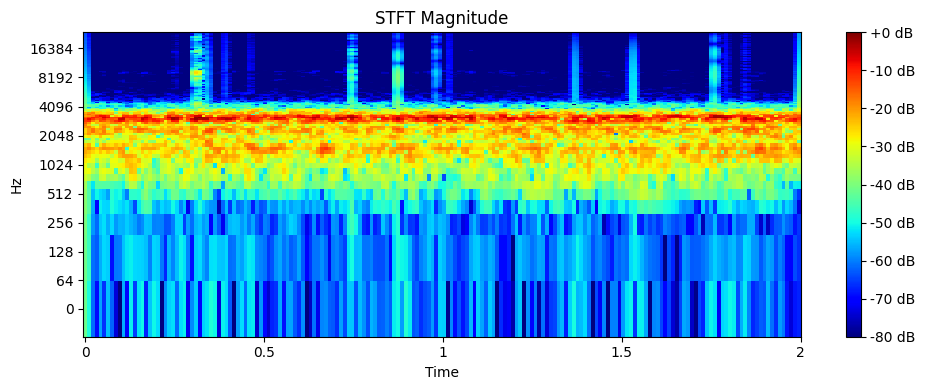

(192, 188)


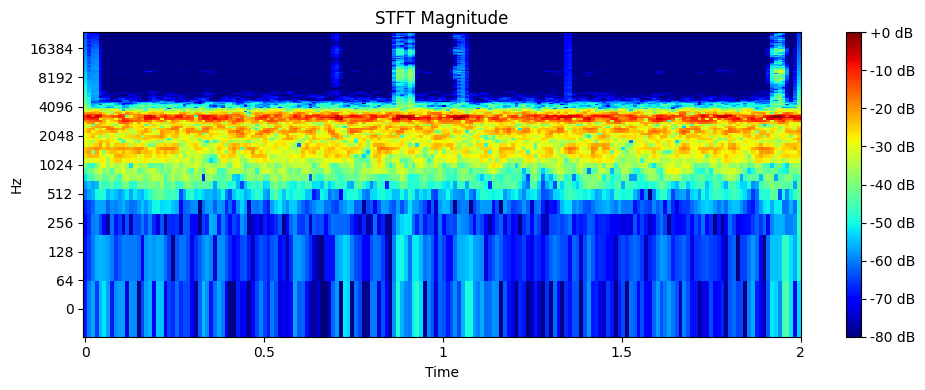

(192, 188)


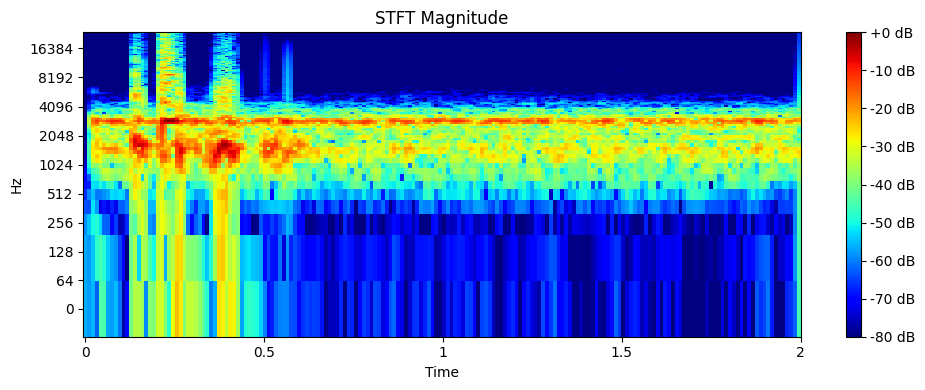

(192, 188)


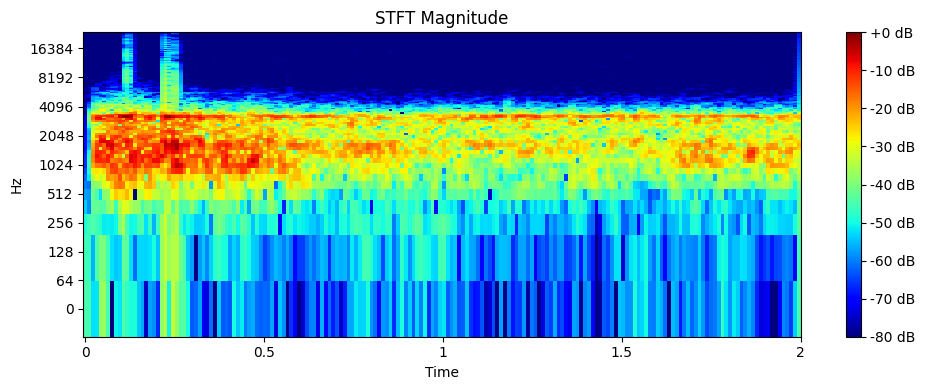

(192, 188)


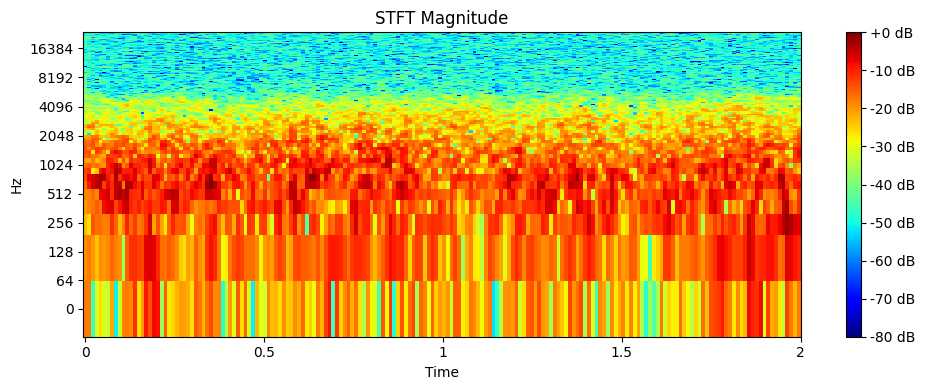

In [25]:
# 繪製 STFT 頻譜圖
for i in X_test:
    S_db = extract_stft_features(i, sr=48000, n_fft=2048, hop_length=512)
    print(S_db.shape)
    plot_stft(S_db, sr=48000, hop_length=512)